In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import ast
import os
import pickle
import json

from sklearn.metrics import mean_squared_error

from pprint import pprint

import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, join_queries_features
from workloads.recsys.recsys_util import get_features, get_feature_update, predict_rating

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
#experiment="results_user_workers_1_random_learningrate_0.02_userfeaturereg_0.01_sleep_0.001"
experiment="results_user_workers_2_key-fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.01"

In [213]:
experiment="results_user_workers_2_key-fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.01"
df = pd.read_csv(f"/home/eecs/wooders/experiments/{experiment}.csv")
print(df[df["past_updates"] != 0].error.mean())
df.error.mean()

0.8389195970407741


0.9195248125801637

In [207]:
experiment="results_user_workers_2_random_learningrate_0.02_userfeaturereg_0.01_sleep_0.01"
df = pd.read_csv(f"/home/eecs/wooders/experiments/{experiment}.csv")
print(df[df["past_updates"] != 0].error.mean())
df.error.mean()

0.8569106547928912


0.9232079774221076

In [208]:
experiment="results_user_workers_2_bad_learningrate_0.02_userfeaturereg_0.01_sleep_0.01"
df = pd.read_csv(f"/home/eecs/wooders/experiments/{experiment}.csv")
print(df[df["past_updates"] != 0].error.mean())
df.error.mean()

0.8999492860892693


0.9258124588565988

In [210]:
experiment="results_user_workers_2_ml_learningrate_0.02_userfeaturereg_0.01_sleep_0.01"
df = pd.read_csv(f"/home/eecs/wooders/experiments/{experiment}.csv")
print(df[df["past_updates"] != 0].error.mean())
df.error.mean()

1.0737385714097687


0.948298319897669

In [146]:
df.past_updates.value_counts()

0       15642
79        434
2         405
210       383
109       240
        ...  
268         1
172         1
595         1
119         1
1387        1
Name: past_updates, Length: 327, dtype: int64

In [177]:
df[df["past_updates"] != 0].error.mean()

0.8999492860892693

In [152]:
df[df["past_updates"] > 0]

,Unnamed: 0,prediction,ts,user,past_updates,pending_updates,baseline,staleness,error,oracle,label
678,678,4.014400,5905,414,678,3,3.721784,9.701715,0.000181,4.000954,4.0
679,679,3.657013,5905,414,678,3,3.318390,9.701715,0.117925,4.000415,4.0
680,680,4.121856,5905,414,678,3,3.614318,9.701715,0.013583,4.005309,4.0
681,681,1.830667,7661,414,681,1,1.889115,4.492603,1.364915,2.998963,3.0
682,682,3.484693,9355,414,682,1,3.233982,4.340501,0.266473,4.000903,4.0
...,...,...,...,...,...,...,...,...,...,...,...
24613,24613,4.129463,15775,362,2,5,4.122393,10.645875,0.140128,4.503800,4.5
24614,24614,4.534038,15776,362,2,6,4.525952,10.651695,0.286585,3.998701,4.0
24643,24643,2.122862,827,567,5,1,2.097736,2.914648,0.138857,2.495496,2.5
24644,24644,2.796314,925,567,5,2,2.751416,3.234117,0.042306,3.001998,3.0


In [79]:
df["baseline_error"] = df[["baseline", "label"]].apply(lambda x: print(x))
df

0        3.478210
1        4.247243
2        4.338513
3        4.125871
4        4.113813
           ...   
23386    2.044478
23387    1.832175
23388    3.215661
23389    3.268939
23390    4.193177
Name: baseline, Length: 23391, dtype: float64
0        5.0
1        4.0
2        5.0
3        5.0
4        5.0
        ... 
23386    4.0
23387    5.0
23388    3.0
23389    2.0
23390    2.5
Name: label, Length: 23391, dtype: float64


,Unnamed: 0,prediction,ts,user,past_updates,pending_updates,baseline,staleness,error,oracle,label,baseline_error
0,0,3.478210,760,414,0,5,3.478210,0.0,2.315643,4.999934,5.0,NaN
1,1,4.247243,760,414,0,5,4.247243,0.0,0.060377,4.001525,4.0,NaN
2,2,4.338513,760,414,0,5,4.338513,0.0,0.443805,5.004700,5.0,NaN
3,3,4.125871,760,414,0,5,4.125871,0.0,0.761982,4.998787,5.0,NaN
4,4,4.113813,760,414,0,5,4.113813,0.0,0.791451,5.003449,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23386,23386,2.044478,7391,1,0,1,2.044478,0.0,3.774475,3.987279,4.0,NaN
23387,23387,1.832175,263,185,0,1,1.832175,0.0,9.814410,4.964971,5.0,NaN
23388,23388,3.215661,15620,591,0,1,3.215661,0.0,0.045265,3.002906,3.0,NaN
23389,23389,3.268939,939,100,0,1,3.268939,0.0,1.613151,1.998840,2.0,NaN


In [ ]:
df = 

In [69]:
np.log(df.groupby("user").error.mean())

user
1      1.328261
4      0.982921
7      0.183413
10     0.638623
11    -0.348690
         ...   
603    0.413006
605   -0.409781
606   -0.473384
607   -0.121070
608   -0.140983
Name: error, Length: 240, dtype: float64

In [55]:
df.groupby("user").staleness.mean()

user
1        0.000000
4       99.011559
7      128.117636
10      20.409890
11       0.509548
          ...    
603      0.403060
605      0.390720
606     15.652394
607    417.664739
608     15.800097
Name: staleness, Length: 240, dtype: float64

In [48]:
df.groupby("past_updates").error.mean().index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1333, 1334, 1335, 1339, 1340, 1345, 1387, 1391, 1392, 1393],
           dtype='int64', name='past_updates', length=519)

In [24]:
df.staleness.mean()

36.493310078300084

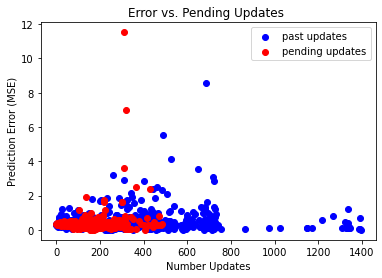

In [51]:
plt.scatter(df.groupby("past_updates").error.median().index.tolist(), df.groupby("past_updates").error.median().tolist(), c ="blue", label="past updates")

plt.legend()
# To show the plot
plt.title("Error vs. Pending Updates ")
plt.ylabel("Prediction Error (MSE)")
plt.xlabel("Number Updates")
plt.show()

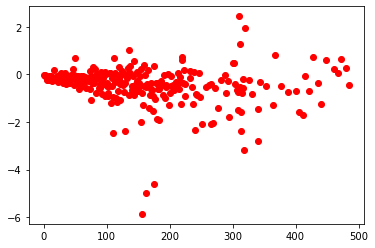

In [70]:
plt.scatter(df.groupby("pending_updates").error.mean().index.tolist(), np.log(df.groupby("pending_updates").error.mean()), c ="red", label="pending updates")


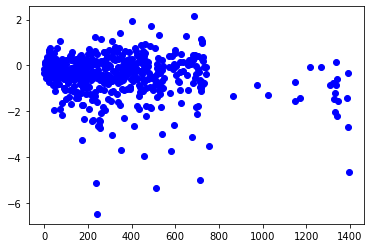

In [71]:
plt.scatter(df.groupby("past_updates").error.mean().index.tolist(), np.log(df.groupby("past_updates").error.mean()), c ="blue", label="pending updates")


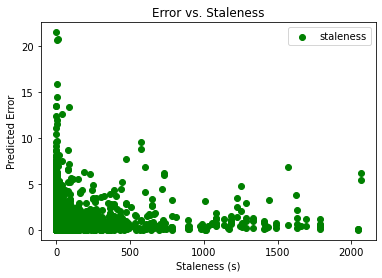

In [53]:
import matplotlib.pyplot as plt

#plt.scatter(df["staleness"].tolist(), df["error"].tolist(), c ="green", label=f"staleness")

plt.scatter(df.groupby("staleness").error.mean().index.tolist(), df.groupby("staleness").error.mean().tolist(), c ="green", label="staleness")

plt.legend()
# To show the plot
plt.title("Error vs. Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

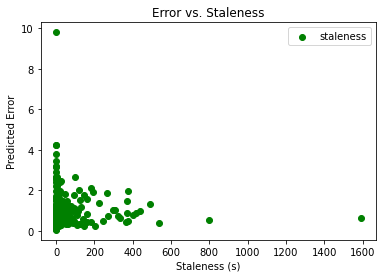

In [56]:
import matplotlib.pyplot as plt

#plt.scatter(df["staleness"].tolist(), df["error"].tolist(), c ="green", label=f"staleness")

plt.scatter(df.groupby("user").staleness.mean().tolist(), df.groupby("user").error.mean().tolist(), c ="green", label="staleness")

plt.legend()
# To show the plot
plt.title("Error vs. Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

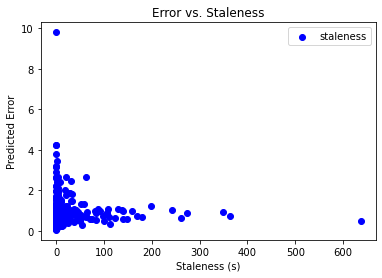

In [61]:
import matplotlib.pyplot as plt

#plt.scatter(df["staleness"].tolist(), df["error"].tolist(), c ="green", label=f"staleness")

plt.scatter(df.groupby("user").past_updates.mean().tolist(), df.groupby("user").error.mean().tolist(), c ="blue", label="staleness")

plt.legend()
# To show the plot
plt.title("Error vs. Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

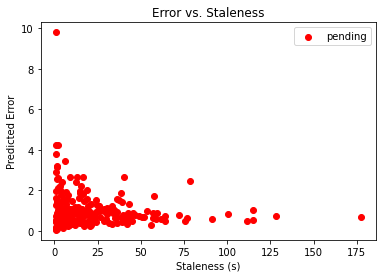

In [60]:
import matplotlib.pyplot as plt

#plt.scatter(df["staleness"].tolist(), df["error"].tolist(), c ="green", label=f"staleness")

plt.scatter(df.groupby("user").pending_updates.mean().tolist(), df.groupby("user").error.mean().tolist(), c ="red", label="pending")

plt.legend()
# To show the plot
plt.title("Error vs. Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

In [82]:
dataset_dir = use_dataset("ml-latest-small")
events_df = pd.read_csv(f'{dataset_dir}/test.csv')

/data/wooders/ralf-vldb//datasets/ml-latest-small


In [83]:
events_df

,Unnamed: 0,user_id,movie_id,rating,timestamp
0,6132,42,2424,4.0,81
1,38927,268,1093,1.0,81
2,31275,217,2231,4.0,81
3,80503,509,4700,3.5,81
4,80447,509,2059,2.5,81
...,...,...,...,...,...
44120,64984,414,179817,4.0,5641265
44121,64934,414,140715,4.0,5641267
44122,64918,414,122906,4.0,5665416
44123,64991,414,187595,3.5,5665417


In [85]:
events_df.timestamp.value_counts()

813        72
109        66
100        63
118        63
81         60
           ..
3316379     1
207217      1
2085778     1
567649      1
2625538     1
Name: timestamp, Length: 13810, dtype: int64

<AxesSubplot:>

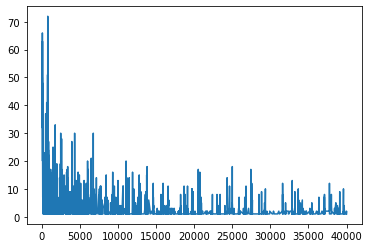

In [92]:
events_df[events_df["timestamp"] < 40000].timestamp.value_counts().sort_index().plot()

In [87]:
25226*0.3

7567.799999999999